In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
from easydict import EasyDict
cfg = EasyDict()
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = 16
cfg.OUT_SIZE = 1
cfg.TRAIN = EasyDict()
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.TRAIN.EPOCH_NUM = 1000
cfg.gm_num = 4
cfg.ndim = 6
cfg.NAME = 'conv2_net_no_bn_ndim%i'%(cfg.ndim)#'conv_net_no_bn_ndim12010'#

In [3]:
from loader import TieLoader,data_generator
train_loader = TieLoader('train_ties1',0.2,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)
test_loader = TieLoader('test_ties',0.2,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)

203.0 48.0


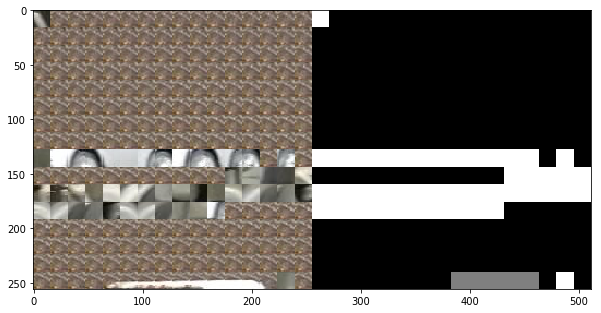

In [4]:
from dataset_tools import draw

for x,y in data_generator(train_loader,epoch_size=1,shuffle=True):
    print np.ones_like(y)[y<0.1].sum(),np.ones_like(y)[y>0.9].sum()
    x = np.transpose(x,(0,2,3,1)).astype(np.uint8)
    y = (y*255.).astype(np.uint8)
    _y = np.zeros(x.shape[:3],dtype=np.uint8)
    _y[:] = y[:,0,0][:,None,None]
    draw(x,_y)

In [5]:
import theano
import theano.tensor as T
from utils import get_network_str,save_weights,load_weights
import lasagne
from lasagne import layers as L
from lasagne.nonlinearities import rectify
from lasagne.regularization import regularize_network_params,l2
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise
from theano_utils import split,histogram_loss

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Build model

In [18]:
data = T.tensor4(name='data')
label = T.tensor3(name='label')

def make_conv(data,num_filters,name,nonl = rectify):
    return L.Conv2DLayer(data,filter_size=(3,3),num_filters=num_filters,
                        nonlinearity=nonl,pad='same',
                        name='conv'+str(name))
    
def make_deconv(data,num_filters,name):
    return  L.Deconv2DLayer(data,12,2,2,crop='valid',name='deconv'+str(name),nonlinearity=rectify)

def FCN(data,ndim=cfg.ndim,verbose=True,model_name=''):
    data = T.concatenate([data[1:],data[:-1]],axis=1)
    datal = res = L.InputLayer((None,6,None,None)
                           ,data
                           ,name='data')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=6,
                        nonlinearity=rectify,pad='same',
                        name='conv1')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=12,
                        nonlinearity=rectify,pad='same',
                        name='conv2')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=ndim,
                        nonlinearity=None,pad='same',
                        name='conv3')
    if(model_name != ''):
        load_weights(res,model_name)
    print get_network_str(res,incomings=True,outgoings=True)
    sym = lasagne.layers.get_output(res)
    sym = T.transpose(sym,(0,2,3,1))
    #sym = T.clip(sym,1e-5,1e5)
    sym = sym/(T.sqrt(T.square(sym).sum(-1)+1e-8)[:,:,:,None])
    params = lasagne.layers.get_all_params(res, trainable=True)
    l2_loss = 1e-4 * regularize_network_params(res, l2)
    return res,sym,params,l2_loss
               

def soft_predict_sym(features,means,covars,weights):
    return 1.-T.nnet.sigmoid(calc_log_prob_gmm(features,means,covars,weights))

# Train

In [19]:
data = T.tensor4(name='data')
label = T.tensor3(name='label')
net,X,params,l2_loss = FCN(data,ndim=cfg.ndim,model_name='')#'models/conv1_net_no_bn_ndim12000')
def get_output(X,t=cfg.TILE_SIZE,o=cfg.OUT_SIZE):
    return X[:,(t-o)//2:(t+o)//2,(t-o)//2:(t+o)//2,:]

X = get_output(X)
X = X.reshape((-1,X.shape[-1]))


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 6, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 6, None, None) 


In [20]:
def make_train_fn(net,X,params,l2_loss,model_name=''):
    def split_tr_p_n(x,y):
        x_tr_p,x_n = split(x,y)
        x_p = x_tr_p[100:]
        x_tr = x_tr_p[:100]
        return x_tr,x_p,x_n    
    x_tr,x_p,x_n = split_tr_p_n(X,label[1:].flatten())    
    m,c,w = get_gmm(x_tr,cfg.gm_num,cfg.ndim,use_approx_grad=True)
    
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,1e-4,100)[0]+l2_loss#+\
            #10.*(T.mean(T.clip(p_n,-40,100)))#-T.mean(T.clip(p_p,-100,40)))
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))
    updates = lasagne.updates.adam(loss,params,G_lr)
    train_fn = theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True, updates=updates)
    print 'train_fn compiled'
    test_fn =  theano.function([data, label], [loss,X,Y,prediction,m,c,w,p_p,p_n],\
                               allow_input_downcast=True)
    print 'test_fn compiled'
    return train_fn,test_fn,G_lr,net

train_fn,test_fn,G_lr,net=make_train_fn(net,X,params,l2_loss)

train_fn compiled
test_fn compiled


In [27]:
G_lr.set_value(np.float32(.01))

In [28]:
hard = []
cur = 0

In [29]:
from sklearn.metrics import average_precision_score

def get_pp_pn(l,pred):
    r = .5
    o = np.ones(len(l))
    pn = o[(pred > r)&(l>0.9)].sum()/o[l>0.9].sum()
    pp = o[(pred < r)&(l<0.1)].sum()/o[l<0.1].sum()
    return pp,pn

models_acc = []
for j in range(0,15):
    train_loss=0
    train_acc=0
    pp,pn = 0,0
    for i,batch in enumerate(data_generator(train_loader,epoch_size=100,shuffle=True)):        
        res = train_fn(*batch)
        mask = (res[2]>0.9) | (res[2]<0.1)
        acc = average_precision_score(res[2][mask],res[3][mask])
        train_acc +=acc
        train_loss+=res[0]
        r = get_pp_pn(res[2][mask],res[3][mask])
        pp+=r[0]
        pn+=r[1]
#         if(res[0] > 1000 ):
#             if( len(hard) < 1000):
#                 hard.append(batch)
#             else:
#                 hard[cur] = batch
#                 cur = (cur+1) % len(hard)
        for k in range(min(3,len(hard))):
            batch = hard[np.random.randint(0,len(hard))]
            res = train_fn(*batch)
        print '\r epoch %i batch %i loss=%.2f ,acc=%.2f,pp=%.2f,pn=%.2f, l=%.2f a=%.2f'%\
        (j,i,train_loss/float(i+1),train_acc/float(i+1),pp/float(i+1),pn/float(i+1),res[0],acc),
    print ''
    
    train_loss=0
    train_acc=0
    pp,pn = 0,0
    for i,batch in enumerate(data_generator(test_loader,epoch_size=200,shuffle=True)):
        res = test_fn(*batch)
        mask = (res[2]>0.9) | (res[2]<0.1)
        acc = average_precision_score(res[2][mask],res[3][mask])
        r = get_pp_pn(res[2][mask],res[3][mask])
        pp+=r[0]
        pn+=r[1]
        train_acc +=acc
        train_loss+=res[0]
        print '\r test batch %i loss=%.2f ,acc=%.2f,pp=%.2f,pn=%.2f, l=%.2f a=%.2f,'%\
        (i,train_loss/float(i+1),train_acc/float(i+1),pp/float(i+1),pn/float(i+1),res[0],acc),
    models_acc.append(train_acc)
    print ''
    
    save_weights(net,'models/%s%03d'%(cfg.NAME,j))
    if(j == 10):
        G_lr.set_value(np.float32(0.01))
    print ''

 epoch 0 batch 99 loss=1037.01 ,acc=0.98,pp=0.90,pn=0.92, l=346.85 a=1.00                                
 test batch 199 loss=1493.76 ,acc=0.96,pp=0.78,pn=0.93, l=2973.84 a=0.92,                              
checkpoint models/conv2_net_no_bn_ndim6000.npz

 epoch 1 batch 99 loss=834.36 ,acc=0.97,pp=0.91,pn=0.91, l=1482.71 a=0.96                                
 test batch 199 loss=1777.82 ,acc=0.95,pp=0.75,pn=0.93, l=227.78 a=0.99,                                
checkpoint models/conv2_net_no_bn_ndim6001.npz

 epoch 2 batch 99 loss=979.10 ,acc=0.98,pp=0.91,pn=0.90, l=9324.35 a=0.76                                  
 test batch 199 loss=1663.74 ,acc=0.96,pp=0.76,pn=0.93, l=-247.82 a=1.00,                                
checkpoint models/conv2_net_no_bn_ndim6002.npz

 epoch 3 batch 99 loss=812.23 ,acc=0.98,pp=0.90,pn=0.90, l=-302.13 a=1.00                                
 test batch 199 loss=1772.51 ,acc=0.96,pp=0.77,pn=0.92, l=1820.29 a=0.98,                               
checkpoint

KeyboardInterrupt: 

In [30]:
for i,batch in enumerate(data_generator(test_loader,epoch_size=50,shuffle=False)):
    res = test_fn(*batch)
    if(i == 0):
        p =res[-1]
        n = res[-2]
    p = np.concatenate((p,res[-1]))
    n = np.concatenate((n,res[-2]))
    

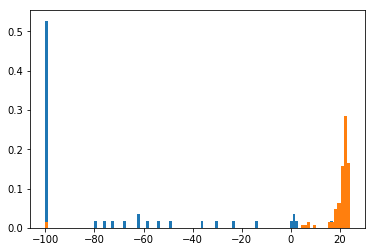

In [31]:
plt.hist(np.clip(res[-1],-100,100),100,normed=True)
plt.hist(np.clip(res[-2],-100,100),100,normed=True)
plt.show()

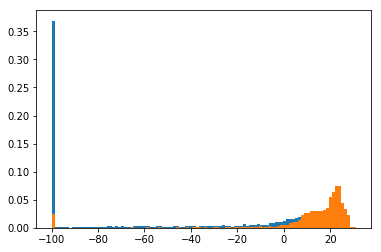

In [32]:
plt.hist(np.clip(p,-100,100),100,normed=True)
plt.hist(np.clip(n,-100,100),100,normed=True)
plt.show()

# Evaluate model

In [33]:
data=T.tensor4()
feature_sym = FCN(data,model_name='models/'+cfg.NAME+'010')[1]
feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 6, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 6, None, None) 


In [34]:
from dataset_tools import *
from gmm_bg_substructor import BgSubstructor
import cv2
import numpy as np
# params = { 'algorithm': 'grimson_gmm', 
#             'low': 1.,#*24*24,
#             'high': 3,#.*24*24,
#             'alpha': 0.01,
#             'max_modes': 5,
#             'channels': 12,
#             'variance': .01,
#             'bg_threshold': 0.075,
#             'min_variance': .005,
#             'variance_factor': 1.}


In [35]:
def make_bgs_test(feature_fn,params,out_name=cfg.NAME,dataset='test_dataset',max_l = 1000,im_size=None,verbose=False,skip_frames=200):
    def make_bgs_features(feature_fn,x):
        return feature_fn(np.transpose(x,(0,3,1,2)))[0]
    out_dir = 'results/'+out_name+'_'+params['algorithm']
    if(not os.path.exists(out_dir)):
        os.mkdir(out_dir)
    f = open('params.txt','w')
    f.write('params\n'+str(params)+'\n')
    f.write('max_l = %i,skip_frames=%i')
    f.close()
    jj = 0
    try:
        for d_in,d_out in iterate_folders(dataset,out_dir):
            jj+=1
            if(jj<1):
                continue
            try:
                bgs = BgSubstructor(params)
                i = 0
                prev =None
                for im,mask in iterate_video(d_in,skip_first_unlabled=False):
                    print '%s %d                   \r'%(d_in,i),
                    if not (im_size is None):
                        im,mask = resize(im,mask,im_size)
                    if(prev is None):
                        prev = im
                        continue
                    tmp = np.concatenate((im[np.newaxis],prev[np.newaxis]),0)
                    features = make_bgs_features(feature_fn,tmp.astype(np.float32))
                    prev = im
                    pred = bgs.update(features.astype(np.float32),im.astype(np.float32))
                    cv2.imwrite(d_out+'/%d.png'%(i),pred)
                    cv2.imwrite(d_out+'/%d_true.png'%(i),mask)
                    cv2.imwrite(d_out+'/%d_input.png'%(i),im)
                    if(verbose):
                        cv2.imshow('pred',pred)
                        cv2.imshow('true',mask)
                        cv2.imshow('input',im)
                        cv2.waitKey(1)
                    if(i >= max_l):
                        break
                    i+=1
                print '%s %d\r'%(d_in,i),
            finally:
                del bgs
    finally:
        if(verbose):
            cv2.destroyAllWindows()
    print 'done'

In [42]:
params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.004,
    'fgAlpha': 0.5,
    'tb': 4,
    'tf': 0.00001,
    'tl': 0.1,
    'init_variance' : 0.1
} 
make_bgs_test(feature_fn,
               out_name=cfg.NAME,
               params=params,
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

delete bgsmentation/test_dataset/badWeather/blizzard 1000                   
delete bgsmentation/test_dataset/baseline/highway 544                   


KeyboardInterrupt: 

In [11]:
params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.004,
    'fgAlpha': 0.5,
    'tb': 3,
    'tf': 20,
    'tl': 0.1,
    'init_variance': 15
}
make_bgs_test(lambda x : np.transpose(x,(0,2,3,1)),
               params,
               out_name='baseline',
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

delete bgsmentation/test_dataset/badWeather/blizzard 1000                   
delete bgsmentation/test_dataset/baseline/highway 1000                   
delete bgsmentation/test_dataset/cameraJitter/badminton 343                   


KeyboardInterrupt: 

In [8]:
data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)

# Find parameters for grimpson gmm

In [19]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *


def find_gmm_params(feature_fn,
              dataset='../gmm_segmentation/test_dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    all_covars = []
    all_weights = []
    all_comp = []
    all_masks = []
    for k,in_dir in enumerate(iterate_folders(dataset)):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms'
            fit_gmms(data,gmms,None)
            cov = np.empty((len(gmms),)+gmms[0].covariances_.shape,dtype=np.float32)
            weights = np.empty((len(gmms),len(gmms[0].weights_)),dtype=np.float32)
            dists = np.empty((len(gmms),len(imgs),len(gmms[0].weights_)),dtype=np.float32)
            data = data.reshape((len(imgs),-1,gmms[i].means_.shape[1]))
            for j in range(len(gmms)):
                cov[j] = gmms[j].covariances_
                weights[j] = gmms[j].weights_
                dists[j] = ((data[:,j,None,:]-gmms[j].means_[None,:,:])**2).sum(-1)
            print 'cov',cov.mean(),cov.std()
            masks = masks.reshape((len(masks),-1))
            masks = np.transpose(masks,(1,0))
            print 'cov bg',dists[masks < 0.5].min(-1).mean(),dists[masks < 0.1].min(-1).std()
            print 'cov motion',dists[masks > 0.5].min(-1).mean(),dists[masks > 0.9].min(-1).std()
            print 'std motion',data[masks > 0.9].std()
            break
    print 'test complete'
    
    
find_gmm_params(feature_fn,max_frames=70,im_size=(50,30))

 ../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms
cov 1.11499e-06 1.74597e-07
cov bg 6.25295e-07 1.03453e-06
cov motion 3.40499e-06 5.45254e-06
std motion ../gmm_segmentation/test_dataset/baseline/highway generate_features, fit gmms
cov 2.85427e-06 4.83695e-06
cov bg 1.05131e-05 2.88201e-05
cov motion 6.92166e-05 9.46624e-05
std motion ../gmm_segmentation/test_dataset/cameraJitter/badminton generate_features, fit gmms
cov 8.72446e-06 1.91739e-05
cov bg 2.63576e-05 6.24374e-05
cov motion 0.000288493 0.000322021
std motion ../gmm_segmentation/test_dataset/thermal/corridor generate_features, fit gmms
cov 1.25252e-06 1.80562e-07
cov bg 1.343e-06 1.37882e-06
cov motion 6.40515e-27 0.0
std motion ../gmm_segmentation/test_dataset/turbulence/turbulence0 generate_features, fit gmms
cov 2.84204e-06 1.92678e-06
cov bg 1.01022e-05 1.38692e-05
cov motion 6.14767e-06 5.83565e-06
std motion test complete


In [ ]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *
def make_test_as_train(feature_fn,predict_fn,
              out_dir='results/'+cfg.NAME,
              dataset='dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    for in_dir,out_dir in iterate_folders(dataset,out_dir):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            if(masks[(masks>30) & (masks < 240)].size > 0.1*masks.size):
                continue
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms,',
            fit_gmms(data[:100],gmms,masks[:100])
            print 'predict,',
            prediction = predict_pixelwise(data[100:],gmms,predict_fn)
            print 'save'
            imgs = imgs[100:]
            masks = masks[100:]      
            prediction = (prediction*255).astype(np.uint8)
            for i in range(len(imgs)):
                cv2.imwrite(out_dir+'/'+str(i)+'.png',prediction[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_true.png',masks[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_input.jpg',imgs[i])
            break
            print ''
    print 'test complete'

In [24]:
make_test_as_train(feature_fn,predict_fn,dataset='../gmm_segmentation/test_dataset')

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms,


# Calc metric

In [41]:
from sklearn.metrics import average_precision_score
import os

def calc_metrics_imgs(predict,label):
    predict,label = predict.flatten(),label.flatten()
    mask = (label>230)|(label < 50)
    p = (predict.astype(np.float32)/255.)[mask]
    y = (label.astype(np.float32)/255.)[mask]
    y[y>0.5] = 1.
    y[y<=0.5] = 0.
    bp = np.zeros_like(p)
    bp[p>0.5] = 1.
    TP = (bp*y).sum()
    TN = ((1-bp)*(1-y)).sum()
    FP = (bp*(1.0-y)).sum()
    FN = ((1.0-bp)*y).sum()
    AveragePrecision = 0#average_precision_score(y,p)
    return np.array([TP,TN,FP,FN],dtype=np.int64),AveragePrecision
    

def print_results(results):
    s = ''
    for k in results.keys():
        s=s+k+str(': ')+str(results[k])+'\n'
    return s

def calc_metrics_folder(data_dir):
    S = np.array([0,0,0,0],dtype=np.int64)
    AveragePrecision = 0.0
    nums = [int(i[:-4]) for i in os.listdir(data_dir) if i.find('true') < 0 and  i.find('input') < 0]
    for i in nums:
        m = cv2.imread(data_dir+'/%i_true.png'%(i))
        p = cv2.imread(data_dir+'/%i.png'%(i))
        cv2.imshow('p',p)
        cv2.waitKey(1)
        _s = calc_metrics_imgs(p,m)
        AveragePrecision += _s[1]
        S+=_s[0]
        
    TP,TN,FP,FN = S[0],S[1],S[2],S[3]
    results = dict( AveragePrecision = AveragePrecision/float(len(nums)),\
                    Recall = TP / float(TP + FN),\
                    Sp = TN / float(TN + FP),\
                    FPR = FP / float(FP + TN),\
                    FNR = FN / float(TP + FN),\
                    PWC =  100 * (FN + FP) / float(TP + FN + FP + TN),\
                    F_Measure  =  (2 * (TP / float(TP + FP)) * (TP / float(TP + FN))) / (TP / float(TP + FP) +  TP / float(TP + FN)),\
                    Precision  = TP / float(TP + FP))
    
    print data_dir
    print print_results(results)
    return results

def calc_metric_all_folders(data_dir):
    res = []
    f = open(data_dir+'.txt','w')
    for j in os.listdir(data_dir):
        folder = data_dir+'/'+j+'/'+os.listdir(data_dir+'/'+j)[0]
        results = calc_metrics_folder(folder)
        if not (results is None):
            res.append(results)
            f.write(folder+'\n')
            f.write(print_results(results))
    results = dict()
    for k in res[0].keys():
        results[k] = np.array([i[k] for i in res if np.isfinite(i[k])]).mean()
    f.write('total result\n')
    f.write(print_results(results))
    f.close()
    print 'total result'
    print print_results(results)

calc_metric_all_folders('results/'+cfg.NAME+'_FTSG')

results/conv2_net_no_bn_ndim6_FTSG/badWeather/blizzard
AveragePrecision: 0.0
FNR: 0.104767594015
Recall: 0.895232405985
Sp: 0.997345700246
Precision: 0.602039254696
PWC: 0.31102709566
FPR: 0.0026542997538
F_Measure: 0.719929542023

results/conv2_net_no_bn_ndim6_FTSG/baseline/highway
AveragePrecision: 0.0
FNR: 0.0244787836629
Recall: 0.975521216337
Sp: 0.978198234931
Precision: 0.703948937067
PWC: 2.19368460946
FPR: 0.0218017650691
F_Measure: 0.817778299823

delete bgs


KeyboardInterrupt: 

In [5]:
import pandas as pd
def parse_results(dir_results):
    for i  in os.listdir(dir_results):
        